In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from pathlib import Path

# Load Data

In [6]:
tourney_data = pd.read_csv("../data/processed/tourney_data.csv")

In [7]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,...,T1_Strength of Schedule_AdjD,T1_NCSOS_AdjT,T2_Rk,T2_AdjEM,T2_AdjO,T2_Strength of Schedule_AdjD,T2_NCSOS_AdjT,T1_seed,T2_seed,SeedDiff
0,2003,134,1421,92,1411,84,0,1,32,69,...,187.0,113.5,260.0,-10.45,98.3,238.0,108.7,16,16,0
1,2003,134,1411,84,1421,92,0,1,29,67,...,238.0,108.7,283.0,-12.35,101.2,187.0,113.5,16,16,0
2,2003,136,1436,51,1112,80,0,0,20,64,...,191.0,99.5,4.0,26.80,115.6,10.0,88.8,16,1,15
3,2003,136,1112,80,1436,51,0,0,31,66,...,10.0,88.8,150.0,1.57,101.1,191.0,99.5,1,16,-15
4,2003,136,1113,84,1272,71,0,0,31,59,...,18.0,97.4,29.0,16.72,110.9,35.0,94.1,10,7,3


# Model Building

In [8]:
# define log-loss scoring
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_val_score, GroupKFold, train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

In [10]:
features1 = [
       'location', 'T1_FGMmean', 'T1_FGAmean', 'T1_FGM3mean', 'T1_FGA3mean',
       'T1_ORmean', 'T1_Astmean', 'T1_TOmean', 'T1_Stlmean', 'T1_PFmean',
       'T1_opponent_FGMmean', 'T1_opponent_FGAmean', 'T1_opponent_FGM3mean',
       'T1_opponent_FGA3mean', 'T1_opponent_ORmean', 'T1_opponent_Astmean',
       'T1_opponent_TOmean', 'T1_opponent_Stlmean', 'T1_opponent_Blkmean',
       'PointDiffmean', 'T2_FGMmean', 'T2_FGAmean', 'T2_FGM3mean',
       'T2_FGA3mean', 'T2_ORmean', 'T2_Astmean', 'T2_TOmean', 'T2_Stlmean',
       'T2_PFmean', 'T2_opponent_FGMmean', 'T2_opponent_FGAmean',
       'T2_opponent_FGM3mean', 'T2_opponent_FGA3mean', 'T2_opponent_ORmean',
       'T2_opponent_Astmean', 'T2_opponent_TOmean', 'T2_opponent_Stlmean',
       'T2_opponent_Blkmean', 'T2_PointDiffmean', 'T1_win_ratio_14d',
       'T2_win_ratio_14d', 'T1_Rk', 'T1_AdjEM', 'T1_AdjO',
       'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT', 'T2_Rk', 'T2_AdjEM',
       'T2_AdjO', 'T2_Strength of Schedule_AdjD', 'T2_NCSOS_AdjT', 'T1_seed',
       'T2_seed', 'SeedDiff'
]

features = [
    'T1_win_ratio_14d',
   'T2_win_ratio_14d', 'T1_Rk', 'T1_AdjEM', 'T1_AdjO',
   'T1_Strength of Schedule_AdjD', 'T1_NCSOS_AdjT', 'T2_Rk', 'T2_AdjEM',
   'T2_AdjO', 'T2_Strength of Schedule_AdjD', 'T2_NCSOS_AdjT', 
]

features2 = [
    
]

df = tourney_data.dropna(how='any')

X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)

# split training and testing:
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=random_state)

In [11]:
def print_score(m):
    res = {
        "train log loss":log_loss(y_train, m.predict(X_train)), 
        "val log loss" : log_loss(y_val, m.predict(X_val)),
        "training r^2" : m.score(X_train, y_train), 
        "validation r^2" : m.score(X_val, y_val)
        }
    if hasattr(m, 'oob_score_'): 
        res['oob score'] = m.oob_score_
    for label, val in res.items(): 
        print(label + ": ", val)

## Random Forest
Just to get warmed up again.

In [12]:
random_state = 1
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

%time model.fit(X_train, y_train)

print_score(model)

Wall time: 248 ms
train log loss:  0.13660838873292766
val log loss:  0.8844583068628453
training r^2:  0.8993459804942714
validation r^2:  0.284336286653185


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:815: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


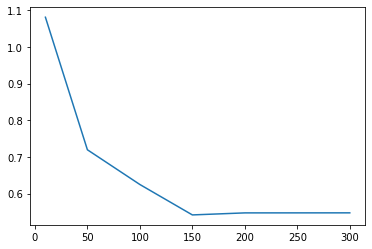

In [13]:
n_trees = [10, 50, 100, 150, 200, 300]
val_log_loss = []
for n in n_trees:
    model = RandomForestRegressor(
        n_estimators=n, n_jobs=-1, oob_score=True, random_state=random_state
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(n_trees, val_log_loss)

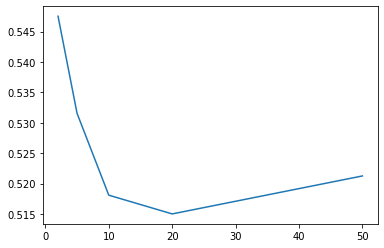

In [14]:
params = dict(
    n_jobs=-1,
    oob_score=True, 
    n_estimators=150,
)

min_samples_leaf = [2, 5, 10, 20, 50]
val_log_loss = []
for msl in min_samples_leaf:
    model = RandomForestRegressor(  
        min_samples_leaf=msl,
        **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(min_samples_leaf, val_log_loss)

In [15]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['min_samples_leaf'] = min_samples_leaf[idx]

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 150, 'min_samples_leaf': 20}


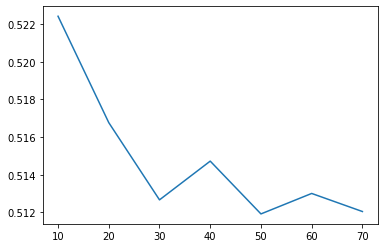

In [16]:
max_leaf_nodes = [10, 20, 30, 40, 50, 60, 70]
print(params)

val_log_loss = []
for m in max_leaf_nodes:
    model = RandomForestRegressor(
     max_leaf_nodes=m, **params
    )
    model.fit(X_train, y_train)
    val_log_loss.append(log_loss(y_val, model.predict(X_val)))

plt.plot(max_leaf_nodes, val_log_loss)

In [17]:
val, idx = min((val, idx) for (idx, val) in enumerate(val_log_loss))
params['max_leaf_nodes'] = max_leaf_nodes[idx]
print("Max leaf nodes: ", max_leaf_nodes[idx])

Max leaf nodes:  50


In [18]:
print(params)
model = RandomForestRegressor(
     **params
    )
model.fit(X_train, y_train)
print_score(model)

{'n_jobs': -1, 'oob_score': True, 'n_estimators': 150, 'min_samples_leaf': 20, 'max_leaf_nodes': 50}
train log loss:  0.40335940392135633
val log loss:  0.512960051902188
training r^2:  0.47509892247342517
validation r^2:  0.31002327963533727
oob score:  0.3356668854796848


## CV Pipe

In [19]:
from sklearn.model_selection import LeaveOneGroupOut
def cv_score(m, X_test_, y_test_, print_=True):
    res = log_loss(y_test_, m.predict(X_test_))
    if print_: print(f"Val log loss: {res}")
    return res

def leave_one_out_CV(estimater, params, folds, df, features):
    X = df[features].copy()
    y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
    groups = df['Season'].values - 2003

    # split training and testing:
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


    cv_res = {}
    group_kfold = LeaveOneGroupOut()
    groups_ = groups[X_train.index]

    for i in range(folds):
        cv_res[i] = []
        for train_index, test_index in group_kfold.split(X_train.values, y_train, groups_):
            X_train_, X_test_ = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_, y_test_ = y_train[train_index], y_train[test_index]

            if hasattr(estimater, "random_state"):
                params['random_state'] = i

            m = estimater(**params)
            m.fit(X_train_, y_train_)
            cv_res[i].append(cv_score(m, X_test_, y_test_, print_=False))
        print(f"Fold {i} Log Loss: {np.mean(cv_res[i])}")

    cv_results = [np.mean(vals) for i, vals in cv_res.items()]
    print("CV Fold Results", cv_results)
    print("Mean CV Log Loss: ", np.mean(cv_results))

In [20]:
df = tourney_data.dropna(how='any').reset_index(drop=True)

leave_one_out_CV(estimater=RandomForestRegressor, params=params, 
                 folds=3, df=df, features=features)

Fold 0 Log Loss: 0.505333130180317
Fold 1 Log Loss: 0.5040502663288713
Fold 2 Log Loss: 0.5041369030382725
CV Fold Results [0.505333130180317, 0.5040502663288713, 0.5041369030382725]
Mean CV Log Loss:  0.5045067665158203


In [21]:
from sklearn.model_selection import GridSearchCV

def custom_scoring(estimator, X, y):
    return log_loss(y, estimator.predict(X))

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)


cv_res = {}
logo = LeaveOneGroupOut()
groups_ = groups[X_train.index]

param_grid = {
    'n_estimators' : [10, 50, 100, 150, 200, 300],
    'min_samples_leaf' : [2, 5, 10, 20, 50],
    'max_leaf_nodes' : [10, 20, 30, 40, 50, 60, 70]
}


gs_cv = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_grid,
    scoring=None,
    n_jobs=-1,
    cv=logo.split(X_train, y_train, groups_),
    verbose=True
)

gs_cv.fit(X_train, y_train)

Fitting 17 folds for each of 210 candidates, totalling 3570 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3570 out of 3570 | elapsed:  3.8min finished


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x0000025DCE657648>,
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                 

In [22]:
best_model = gs_cv.best_estimator_

print(f"Best params: {gs_cv.best_params_}")
print_score(best_model)

Best params: {'max_leaf_nodes': 20, 'min_samples_leaf': 2, 'n_estimators': 300}
train log loss:  0.4067260131631536
val log loss:  0.50595963487314
training r^2:  0.4833226046018928
validation r^2:  0.31938667607190174


# Linear Models

In [32]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def custom_scoring(estimator, X, y):
    return 1/log_loss(y, estimator.predict(X))

ridge = linear_model.Ridge()

# use grid search CV to hyper parameter tune properly:
df = tourney_data.dropna(how='any').reset_index().copy()
X = df[features].copy()
y = np.where(df['T1_Score'] - df['T2_Score'] > 0, 1, 0)
groups = df['Season'].values - 2003

# split training and testing:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

groups = groups[X_train.index]

logo = LeaveOneGroupOut()

cv_score = cross_val_score(
        estimator=ridge,
        X=X_train,
        y=y_train,
        groups=groups,
        scoring = custom_scoring,
        cv = logo.split(X_train, y_train, groups),
        n_jobs=-1,
        verbose=0,
    )

In [57]:
# bulk trial:
estimators = [
    linear_model.BayesianRidge(),
    linear_model.ARDRegression(),
    linear_model.ElasticNetCV(),
    linear_model.ElasticNet(),
    linear_model.Lasso(),
    linear_model.LogisticRegression(),
    linear_model.SGDRegressor()
]

scores = {}

for est in estimators:
    scores[est.__class__.__name__] = np.mean(1/cross_val_score(
        estimator=est,
        X=X_train,
        y=y_train,
        groups=groups,
        scoring = custom_scoring,
        cv = logo.split(X_train, y_train, groups),
        n_jobs=-1,
        verbose=0,
    ))

In [58]:
scores

{'BayesianRidge': 0.5388372332215334,
 'ARDRegression': 0.5400969707584765,
 'ElasticNetCV': 0.5386575808027512,
 'ElasticNet': 0.5602435639098499,
 'Lasso': 0.5649386680483847,
 'LogisticRegression': 8.531066548191909,
 'SGDRegressor': 18.10431395223673}